In [1]:
#######################
# IMPORTING LIBRARIES #
#######################

import pandas as pd
import numpy as np
from datetime import datetime

import pycountry  # To convert country names to 3 letter code
import webbrowser

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import pickle

In [2]:
################
# DATA PARSING #
################

# Functions for gathering datasets from John Hopkins's repository
base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

def worldData(fileName, columnName):
    data = pd.read_csv(base_url + fileName) \
             .melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='date', value_name=columnName) \
             .fillna('<all>')
    data['date'] = data['date'].astype('datetime64[ns]')
    return data

def usData(fileName, columnName):
    data = pd.read_csv(base_url + fileName) \
             .melt(id_vars=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'], var_name='date', value_name=columnName) \
             .fillna('<all>')
    # Get names of indexes for which column Date has extra strings has value 30
    indexNames = data[data['date'] == 'Population'].index
    # Delete these row indexes from dataFrame
    data.drop(indexNames, inplace=True)
    data['date'] = data['date'].astype('datetime64[ns]')
    return data

########################

# US data
us_data = usData("time_series_covid19_confirmed_US.csv", "Confirmed") \
    .merge(usData("time_series_covid19_deaths_US.csv", "Deaths"))
#us_data.head()

# World data
world_data = worldData("time_series_covid19_confirmed_global.csv", "Confirmed") \
    .merge(worldData("time_series_covid19_deaths_global.csv", "Deaths"))
#world_data.head()

########################

In [3]:
us_data.head()

UID iso2 iso3  code3  FIPS   Admin2            Province_State  \
0       316   GU  GUM    316    66    <all>                      Guam   
1       580   MP  MNP    580    69    <all>  Northern Mariana Islands   
2       630   PR  PRI    630    72    <all>               Puerto Rico   
3       850   VI  VIR    850    78    <all>            Virgin Islands   
4  84001001   US  USA    840  1001  Autauga                   Alabama   

  Country_Region        Lat       Long_                  Combined_Key  \
0             US  13.444300  144.793700                      Guam, US   
1             US  15.097900  145.673900  Northern Mariana Islands, US   
2             US  18.220800  -66.590100               Puerto Rico, US   
3             US  18.335800  -64.896300            Virgin Islands, US   
4             US  32.539527  -86.644082          Autauga, Alabama, US   

        date  Confirmed  Deaths  
0 2020-01-22          0       0  
1 2020-01-22          0       0  
2 2020-01-22          0       0  
3 2020-01-22          0       0  
4 2020-01-22          0       0

In [4]:
world_data.head()

Province/State Country/Region      Lat     Long       date  Confirmed  \
0          <all>    Afghanistan  33.0000  65.0000 2020-01-22          0   
1          <all>        Albania  41.1533  20.1683 2020-01-22          0   
2          <all>        Algeria  28.0339   1.6596 2020-01-22          0   
3          <all>        Andorra  42.5063   1.5218 2020-01-22          0   
4          <all>         Angola -11.2027  17.8739 2020-01-22          0   

   Deaths  
0       0  
1       0  
2       0  
3       0  
4       0

In [5]:
# Transforming datasets
grouped_countries = world_data.groupby(['date','Country/Region', 'Province/State']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()
grouped_states = us_data.groupby([ 'date', 'Province_State', 'FIPS', 'Lat', 'Long_']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()

In [6]:
grouped_countries.head()

date Country/Region Province/State  Confirmed  Deaths
0 2020-01-22    Afghanistan          <all>          0       0
1 2020-01-22        Albania          <all>          0       0
2 2020-01-22        Algeria          <all>          0       0
3 2020-01-22        Andorra          <all>          0       0
4 2020-01-22         Angola          <all>          0       0

In [7]:
grouped_states.head()

date Province_State  FIPS        Lat      Long_  Confirmed  Deaths
0 2020-01-22        Alabama  1001  32.539527 -86.644082          0       0
1 2020-01-22        Alabama  1003  30.727750 -87.722071          0       0
2 2020-01-22        Alabama  1005  31.868263 -85.387129          0       0
3 2020-01-22        Alabama  1007  32.996421 -87.125115          0       0
4 2020-01-22        Alabama  1009  33.982109 -86.567906          0       0

In [8]:
# Opening pickled dictionary with demographics data of percentage of population over 65
with open('./pickled_files/age_dict.pkl', 'rb') as f:
    over_65_dict = pickle.load(f)
#over_65_dict

In [9]:
# Opening pickled dictionary with country data
with open('./pickled_files/dev_index_dict.pkl',  'rb') as f:
    dev_index_dict = pickle.load(f)
#dev_index_dict

In [10]:
##############################################
# CODE TO ADD COUNTRY CODES TO ALL COUNTRIES #
##############################################

import pycountry # To convert country names to 3 letter code

# Finding 3 letter codes of countries in our dataset
input_countries = grouped_countries['Country/Region']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

codes = [countries.get(country, 'Unknown code') for country in input_countries]

#print(codes)
grouped_countries['code'] = codes
grouped_countries.head()

# Generating a dictionary with countries and codes
# First finding all countries with codes
only_countries = grouped_countries.groupby(['Country/Region', 'code']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()
with_codes = only_countries[only_countries.code != 'Unknown code'][['Country/Region', 'code']]
country_code_dict = dict(zip(with_codes['Country/Region'], with_codes['code']))

with open('pickled_files/country_code_dict.pkl', 'wb') as f:
    pickle.dump(country_code_dict, f)
#country_code_dict

# Checking for missing countries with missing codes
no_codes = grouped_countries[grouped_countries.code == 'Unknown code'][['Country/Region']]
countries_to_augment = no_codes['Country/Region'].unique()
countries_to_augment

# Manually adding missing codes
codes_to_add = ['BOL', 'BWN', 'MMR', 'COG', 'COD', 'CIV', 'UNK', 'VAT', 'IRN', 'KOR', 'RKS', 'LAO', 'UNK', 'MDA', 'RUS', 'SYR', 'TWN', 'TZA', 'USA', 'VEN', 'VNM', 'PSE']
augmentation_dict = dict(zip(countries_to_augment, codes_to_add))
#augmentation_dict

# Augmenting previous dictionary
complete_country_code_dict = {**augmentation_dict, **country_code_dict} 
with open('pickled_files/complete_country_code_dict.pkl', 'wb') as f:
    pickle.dump(complete_country_code_dict, f)


complete_country_code_dict

{'Bolivia': 'BOL',
 'Brunei': 'BWN',
 'Burma': 'MMR',
 'Congo (Brazzaville)': 'COG',
 'Congo (Kinshasa)': 'COD',
 "Cote d'Ivoire": 'CIV',
 'Diamond Princess': 'UNK',
 'Holy See': 'VAT',
 'Iran': 'IRN',
 'Korea, South': 'KOR',
 'Kosovo': 'RKS',
 'Laos': 'LAO',
 'MS Zaandam': 'UNK',
 'Moldova': 'MDA',
 'Russia': 'RUS',
 'Syria': 'SYR',
 'Taiwan*': 'TWN',
 'Tanzania': 'TZA',
 'US': 'USA',
 'Venezuela': 'VEN',
 'Vietnam': 'VNM',
 'West Bank and Gaza': 'PSE',
 'Afghanistan': 'AFG',
 'Albania': 'ALB',
 'Algeria': 'DZA',
 'Andorra': 'AND',
 'Angola': 'AGO',
 'Antigua and Barbuda': 'ATG',
 'Argentina': 'ARG',
 'Armenia': 'ARM',
 'Australia': 'AUS',
 'Austria': 'AUT',
 'Azerbaijan': 'AZE',
 'Bahamas': 'BHS',
 'Bahrain': 'BHR',
 'Bangladesh': 'BGD',
 'Barbados': 'BRB',
 'Belarus': 'BLR',
 'Belgium': 'BEL',
 'Belize': 'BLZ',
 'Benin': 'BEN',
 'Bhutan': 'BTN',
 'Bosnia and Herzegovina': 'BIH',
 'Botswana': 'BWA',
 'Brazil': 'BRA',
 'Bulgaria': 'BGR',
 'Burkina Faso': 'BFA',
 'Burundi': 'BDI',
 'Ca

In [11]:
# Opening pickled country code dictionary
complete_country_code_dict = pd.read_pickle('pickled_files/complete_country_code_dict.pkl')

# Mapping codes to countries in dataset
grouped_countries['code'] = grouped_countries['Country/Region'].map(complete_country_code_dict)
# Double checking missing values
missing_codes = len(grouped_countries[grouped_countries.code == 'Unknown code'][['Country/Region']])
print(f'There are {missing_codes} missing 3-letter codes in dataset')
print('-------')
grouped_countries.head()

There are 0 missing 3-letter codes in dataset
-------


date Country/Region Province/State  Confirmed  Deaths code
0 2020-01-22    Afghanistan          <all>          0       0  AFG
1 2020-01-22        Albania          <all>          0       0  ALB
2 2020-01-22        Algeria          <all>          0       0  DZA
3 2020-01-22        Andorra          <all>          0       0  AND
4 2020-01-22         Angola          <all>          0       0  AGO

In [12]:
# ##############
# # CHOROPLETH #
# ##############

# global_data = grouped_countries.groupby(['Country/Region', 'code']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()

# # Adding Fatality Rates
# global_data['fatalityRate'] = round(global_data.Deaths/global_data.Confirmed*100, 2)
# #global_data.head()

# def world_map():
    

#     fig = px.choropleth(
#                             global_data,
#                             locations='code',
#                             #title="Custom layout.hoverlabel formatting",
#                             hover_name="Country/Region",
#                             hover_data=["Confirmed", "Deaths"],
#                             color=np.log10(global_data["Confirmed"]),
#                             color_continuous_scale='Reds',
#                             #range_color=(0, 100),
#                             labels={
#                                 'Confirmed': 'Confirmed Cases <br> (x10) <br>',
#                                 'Deaths': 'Deaths'
#                             },
#                             #featureidkey="global_data.Deaths",
#                             scope='world',
#                             # animation_frame='date'
#                        )
#     fig.update_layout(template="plotly_dark", margin={
#             "r": 0,
#             "t": 0,
#             "l": 0,
#             "b": 0
#         }, coloraxis_showscale=False,# Set to True to show colorscale bar
#                           coloraxis_colorbar=dict(
#                               title="<b>Confirmed Cases</b> <br>" + "(Log Scale)",
#                               tickvals=[1.5, 2.5, 3.5, 4.5],
#                               ticktext=["100", "1k", "10k", "100k"],
#                               thicknessmode="pixels",
#                               thickness=10,
#                               lenmode="pixels",
#                               len=200,
#                           ),
#                           hovermode="x",
#                           hoverlabel=dict(
#                               bgcolor="#BF4025",
#                               font_size=16,
#                           ),
#                           geo=dict(showframe=False,
#                                    showcoastlines=False,
#                                    projection_type='natural earth'))

#     fig.update_traces(hovertemplate='<b>' + global_data['Country/Region'] +
#                           '</b>' + '<br>' + 'Confirmed Cases: ' +
#                           global_data['Confirmed'].astype(str) + '<br>' +
#                           'Deaths: ' + global_data['Deaths'].astype(str))
#     return fig

In [13]:
#world_map()

In [14]:
# ###############
# # TOTAL CASES #
# ###############

# total_confirmed = global_data.Confirmed.sum()
# total_deaths = global_data.Deaths.sum()
# print(f'Total Confirmed Cases: {total_confirmed}')
# print(f'Total Deaths: {total_deaths}')

In [15]:
# ################
# # LAST UPDATED #
# ################
# last_update = grouped_countries.date.max().strftime("%d-%b-%Y")
# # conv_date = datetime.strptime(last_update, '%d/%m/%y')
# print(last_update)

In [16]:
# ##############
# # BAR CHARTS #
# ##############



# # Limiting graph to countries with more than 1000 cases

# x = global_data[global_data.Confirmed > 1000]["Country/Region"]
# y = global_data[global_data.Confirmed > 1000]["fatalityRate"]

# fig = px.bar(global_data, x=x, y=y)
# fig.update_layout(xaxis={'categoryorder':'total descending'}, template="plotly_dark", yaxis={'title': 'Current Death Rates <br> >1000 cases'})
# fig.show()

In [17]:
# fig = px.line(grouped_countries, x="date", y="Confirmed", color='Country/Region')
# fig.show()

In [18]:
# global_data = grouped_countries.groupby(['Country/Region', 'code']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()
# fig = px.scatter_geo(global_data, locations="code", color="Confirmed",
#                      hover_name="Country/Region", size="Deaths",
#                      projection="natural earth")

# fig.update_layout(template="plotly_dark", margin={
#             "r": 0,
#             "t": 0,
#             "l": 0,
#             "b": 0
#         },coloraxis_showscale=False,
#                           coloraxis_colorbar=dict(
# #                               title="<b>Confirmed Cases</b> <br>" + "(Log Scale)",
# #                               tickvals=[1.5, 2.5, 3.5, 4.5],
# #                               ticktext=["100", "1k", "10k", "100k"],
#                               thicknessmode="pixels",
#                               thickness=10,
#                               lenmode="pixels",
#                               len=200,
#                           ),
#                           hovermode="x",
#                           hoverlabel=dict(
#                               bgcolor="#BF4025",
#                               font_size=16,
#                           ),
#                           geo=dict(showframe=True,
#                                    showcoastlines=True,
#                                    projection_type='natural earth'))

# fig.update_traces(hovertemplate='<b>' + global_data['Country/Region'] +
#                           '</b>' + '<br>' + 'Confirmed Cases: ' +
#                           global_data['Confirmed'].astype(str) + '<br>' +
#                           'Deaths: ' + global_data['Deaths'].astype(str))

# fig.show()

In [19]:
# global_data.head()

In [20]:
# days = list(grouped_countries.date)

# # make list of countries
# countries = []
# for c in grouped_countries["Country/Region"]:
#     if c not in countries:
#         countries.append(c)
# # make figure
# fig_dict = {
#     "data": [],
#     "layout": {},
#     "frames": []
# }

# # fill in most of layout
# fig_dict["layout"]["xaxis"] = {"range": [30, 85], "title": "Life Expectancy"}
# fig_dict["layout"]["yaxis"] = {"title": "GDP per Capita", "type": "log"}
# fig_dict["layout"]["hovermode"] = "closest"
# fig_dict["layout"]["sliders"] = {
#     "args": [
#         "transition", {
#             "duration": 400,
#             "easing": "cubic-in-out"
#         }
#     ],
#     "initialValue": "1952",
#     "plotlycommand": "animate",
#     "values": days,
#     "visible": True
# }
# fig_dict["layout"]["updatemenus"] = [
#     {
#         "buttons": [
#             {
#                 "args": [None, {"frame": {"duration": 500, "redraw": False},
#                                 "fromcurrent": True, "transition": {"duration": 300,
#                                                                     "easing": "quadratic-in-out"}}],
#                 "label": "Play",
#                 "method": "animate"
#             },
#             {
#                 "args": [[None], {"frame": {"duration": 0, "redraw": False},
#                                   "mode": "immediate",
#                                   "transition": {"duration": 0}}],
#                 "label": "Pause",
#                 "method": "animate"
#             }
#         ],
#         "direction": "left",
#         "pad": {"r": 10, "t": 87},
#         "showactive": False,
#         "type": "buttons",
#         "x": 0.1,
#         "xanchor": "right",
#         "y": 0,
#         "yanchor": "top"
#     }
# ]

# sliders_dict = {
#     "active": 0,
#     "yanchor": "top",
#     "xanchor": "left",
#     "currentvalue": {
#         "font": {"size": 20},
#         "prefix": "Day:",
#         "visible": True,
#         "xanchor": "right"
#     },
#     "transition": {"duration": 300, "easing": "cubic-in-out"},
#     "pad": {"b": 10, "t": 50},
#     "len": 0.9,
#     "x": 0.1,
#     "y": 0,
#     "steps": []
# }

# # make data
# day = '1/22/20'
# for c in countries:
#     dataset_by_day = grouped_countries[grouped_countries["date"] == day]
#     dataset_by_day_and_cont = dataset_by_day[
#         dataset_by_day["Country/Region"] == c]

#     data_dict = {
#         "x": list(dataset_by_day_and_cont["date"]),
#         "y": list(dataset_by_day_and_cont["Confirmed"]),
#         "mode": "markers",
# #         "text": list(dataset_by_day_and_cont["country"]),
# #         "marker": {
# #             "sizemode": "area",
# #             "sizeref": 200000,
# #             "size": list(dataset_by_day_and_cont["pop"])
# #         },
#         "name": c
#     }
#     fig_dict["data"].append(data_dict)

# # make frames
# for d in days:
#     frame = {"data": [], "name": str(d)}
#     for c in countries:
#         dataset_by_day = grouped_countries[grouped_countries["date"] == d]
#         dataset_by_day_and_cont = dataset_by_day[
#             dataset_by_day["Country/Region"] == c]

#         data_dict = {
#             "x": list(dataset_by_day_and_cont["date"]),
#             "y": list(dataset_by_day_and_cont["Confirmed"]),
#             "mode": "markers",
#             "text": list(dataset_by_day_and_cont["Country/Region"]),
#             "marker": {
#                 "sizemode": "area",
#                 "sizeref": 200000,
#                 "size": list(dataset_by_day_and_cont["Confirmed"])
#             },
#             "name": c
#         }
#         frame["data"].append(data_dict)

#     fig_dict["frames"].append(frame)
#     slider_step = {"args": [
#         [day],
#         {"frame": {"duration": 300, "redraw": False},
#          "mode": "immediate",
#          "transition": {"duration": 300}}
#     ],
#         "label": day,
#         "method": "animate"}
#     sliders_dict["steps"].append(slider_step)


# fig_dict["layout"]["sliders"] = [sliders_dict]

# fig = go.Figure(fig_dict)

# fig.show()

In [21]:
# fig = go.Figure(
#     data=[go.Scatter(x=[0, 1], y=[0, 1])],
#     layout=go.Layout(
#         xaxis=dict(range=[0, 5], autorange=False),
#         yaxis=dict(range=[0, 5], autorange=False),
#         title="Start Title",
#         updatemenus=[dict(
#             type="buttons",
#             buttons=[dict(label="Play",
#                           method="animate",
#                           args=[None])])]
#     ),
#     frames=[go.Frame(data=[go.Scatter(x=[1, 2], y=[1, 2])]),
#             go.Frame(data=[go.Scatter(x=[1, 4], y=[1, 4])]),
#             go.Frame(data=[go.Scatter(x=[3, 4], y=[3, 4])],
#                      layout=go.Layout(title_text="End Title"))]
# )

# fig.show()

In [22]:
# global_data = grouped_countries.groupby(['Country/Region', 'code']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()
# global_data['deathRate'] = global_data['Deaths']/global_data['Confirmed']
# death_rates = global_data[(global_data['Deaths'] > 0) & (global_data['Confirmed'] >1000)]

# # Country
# # country = grouped_country['Country/Region']


# # Initialize figure with subplots
# fig = make_subplots(
#     rows=2, cols=2,
#     column_widths=[0.6, 0.4],
#     row_heights=[0.5, 0.5],
#     specs=[[{"type": "choropleth", "rowspan":2}, {"type": "bar"}],
#            [                 None               , {"type": "surface"}]])

# # fig.add_trace(
# #     px.choropleth(grouped_countries, locations='code',
# #                     hover_data=["Confirmed", "Deaths"],
# #                     color='Confirmed',
# #                     range_color=(0, 25000),
# #                     color_continuous_scale='orrd', 
# #                     labels={'Confirmed': 'Confirmed Cases (x10)', 'Deaths': 'Deaths'}, 
# #                     featureidkey="grouped_countries.Deaths",
# #                     scope='world'))

# # Add scattergeo globe map
# fig.add_trace(
#     go.Choropleth(
#         locations = global_data['code'],
#         z = global_data['Confirmed'],
# #         text = global_data['Deaths'],
#         colorscale = 'Reds',
#         autocolorscale=False,
#         reversescale=False,
#         marker_line_color='white',
#         marker_line_width=0.2,
#         colorbar_tickprefix = '',
#         colorbar_title = ''
#     ), row=1, col=1
# )

# #Add death rate bar chart
# fig.add_trace(
#     go.Bar(x=death_rates["Country/Region"],y=death_rates["deathRate"], marker=dict(color="crimson"), showlegend=False),
#     row=1, col=2
# )


# fig.update_layout(template="plotly_dark", showlegend=False, xaxis={'categoryorder':'total descending'},
#     annotations=[
#         dict(
# text="Data sources: WHO, CDC, ECDC, NHC, DXY, 1point3acres, Worldometers.info, BNO, state and national government health departments, and local media reports.",
#             showarrow=False,
#             xref="paper",
#             yref="paper",
#             x=0,
#             y=0)
#     ],
#         coloraxis_showscale=False, 
#         margin={
#         "r": 0,
#         "t": 20,
#         "l": 0,
#         "b": 0
#     },
#         coloraxis_colorbar=dict(
#             title="<b>Confirmed Cases</b> <br>" + "(Log Scale)",
#             tickvals=[1.5, 2.5, 3.5, 4.5],
#             ticktext=["100", "1k", "10k", "100k"],
#             thicknessmode="pixels",
#             thickness=10,
#             lenmode="pixels",
#             len=200,
#                       ),
#         hovermode="x",
#         hoverlabel=dict(
#             bgcolor="#BF4025",
#             font_size=16,
#                       )
#                  )

# # Update geo subplot properties
# fig.update_geos(
#     projection_type="natural earth",
#     landcolor="lightgrey",
#     oceancolor="MidnightBlue",
#     showocean=False,
#     lakecolor="white",
#     showframe=False,
#     showcoastlines=True,
#     coastlinewidth=0.2
# )


# # # Add 3d surface of volcano
# # fig.add_trace(
# #     go.Surface(z=df_v.values.tolist(), showscale=False),
# #     row=2, col=2
# # )


# # # Rotate x-axis labels
# fig.update_xaxes()
# fig.update_yaxes(title="Current Death Rates <br> (>1000 cases)}", tickfont=dict(family='Rockwell', color='crimson', size=10))

# #Set theme, margin, and annotation in layout
# # fig.update_layout(showlegend=False, xaxis={'categoryorder':'total descending'}, coloraxis_showscale=False,
# # #             coloraxis_colorbar=dict(
# # #     title="Number of Bills per Cell",
# # #     thicknessmode="pixels", thickness=10,
# # #     lenmode="pixels", len=50,
# # #     yanchor="top", y=1,
# # #     ticks="outside", ticksuffix=" bills",
# # #     dtick=5),      
# #     template="plotly_dark",
# #     margin=dict(r=0, t=0, b=0, l=0),
# #     annotations=[
# #         dict(
# # text="Source: mjkjk",
# #             showarrow=False,
# #             xref="paper",
# #             yref="paper",
# #             x=0,
# #             y=0)
# #     ]
# # )
# fig.update_traces(hovertemplate='<b>' + global_data['Country/Region'] +
#                       '</b>' + '<br>' + 'Confirmed Cases: ' +
#                       [str((f"{num:,d}")) for num in global_data['Confirmed']] + '<br>' +
#                       'Deaths: ' + [str((f"{num:,d}")) for num in global_data['Deaths']] + '<br>' + 
#                       'Current Death Rate: ' + [str(round(num*100, 2)) for num in global_data['deathRate']] + '%' + 
#                       '<extra></extra>')


In [23]:
#################################
########## VERSION 2 ############
#################################

# Version 2

In [24]:
def world_data():
    data=pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv', parse_dates=['Date'])
    return data

In [25]:
df = world_data()
df.head()

Date      Country  Confirmed  Recovered  Deaths
0 2020-01-22  Afghanistan          0          0       0
1 2020-01-22      Albania          0          0       0
2 2020-01-22      Algeria          0          0       0
3 2020-01-22      Andorra          0          0       0
4 2020-01-22       Angola          0          0       0

In [26]:
df

Date             Country  Confirmed  Recovered  Deaths
0     2020-01-22         Afghanistan          0          0       0
1     2020-01-22             Albania          0          0       0
2     2020-01-22             Algeria          0          0       0
3     2020-01-22             Andorra          0          0       0
4     2020-01-22              Angola          0          0       0
...          ...                 ...        ...        ...     ...
14980 2020-04-11  West Bank and Gaza        268         57       2
14981 2020-04-11      Western Sahara          4          0       0
14982 2020-04-11               Yemen          1          0       0
14983 2020-04-11              Zambia         40         28       2
14984 2020-04-11            Zimbabwe         14          0       3

[14985 rows x 5 columns]

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
# %matplotlib inline #if you're working in a Jupyter notebook

# Section 2 - Loading and Selecting Data
df = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv', parse_dates=['Date'])
countries = ['Canada', 'Germany', 'United Kingdom', 'US', 'France', 'China', 'Spain']
df_select = df[df['Country'].isin(countries)].copy()

# Section 3 - Creating a Summary Column
df_select['Cases'] = df_select[['Confirmed']].sum(axis=1)

# Section 4 - Restructuring our Data
df_select = df_select.pivot(index='Date', columns='Country', values='Cases')
countries = list(df_select.columns)
covid = df_select.reset_index('Date')
covid.set_index(['Date'], inplace=True)
covid.columns = countries

# Section 5 - Calculating Rates per 100,000
populations = {'Canada':37664517, 'Germany': 83721496 , 'United Kingdom': 67802690 , 'US': 330548815, 'France': 65239883, 'China':1438027228, 'Spain': 46940000}
percapita = covid.copy()
for country in list(percapita.columns):
    percapita[country] = percapita[country]/populations[country]*100000

In [28]:
df_select.head()

Country     Canada  China  France  Germany  Spain  US  United Kingdom
Date                                                                 
2020-01-22       0    548       0        0      0   1               0
2020-01-23       0    643       0        0      0   1               0
2020-01-24       0    920       2        0      0   2               0
2020-01-25       0   1406       3        0      0   2               0
2020-01-26       1   2075       3        0      0   5               0

In [29]:
# Opening pickled dictionary with population data and mapping to countries
pop_dict = pd.read_pickle('./pickled_files/population_dict.pkl')
# Mapping populations to countries in dataset
df['population'] = df['Country'].map(pop_dict)
# Double checking missing values
missing_populations = len(df[df.population.isna()][['population']])
print(f'There are {missing_populations} missing populations in dataset')
print('-------')
df.head()

There are 1620 missing populations in dataset
-------


Date      Country  Confirmed  Recovered  Deaths  population
0 2020-01-22  Afghanistan          0          0       0   38928.346
1 2020-01-22      Albania          0          0       0    2877.797
2 2020-01-22      Algeria          0          0       0   43851.044
3 2020-01-22      Andorra          0          0       0      77.265
4 2020-01-22       Angola          0          0       0   32866.272

In [30]:
df['confirmedPerCapita'] = df.Confirmed/df.population*100000
df['deathPerCapita'] = df.Deaths/df.population*100000
df.head()

Date      Country  Confirmed  Recovered  Deaths  population  \
0 2020-01-22  Afghanistan          0          0       0   38928.346   
1 2020-01-22      Albania          0          0       0    2877.797   
2 2020-01-22      Algeria          0          0       0   43851.044   
3 2020-01-22      Andorra          0          0       0      77.265   
4 2020-01-22       Angola          0          0       0   32866.272   

   confirmedPerCapita  deathPerCapita  
0                 0.0             0.0  
1                 0.0             0.0  
2                 0.0             0.0  
3                 0.0             0.0  
4                 0.0             0.0

Text(2020-01-23 00:00:00, -100000, 'datagy.io                      Source: https://github.com/datasets/covid-19/blob/master/data/countries-aggregated.csv')

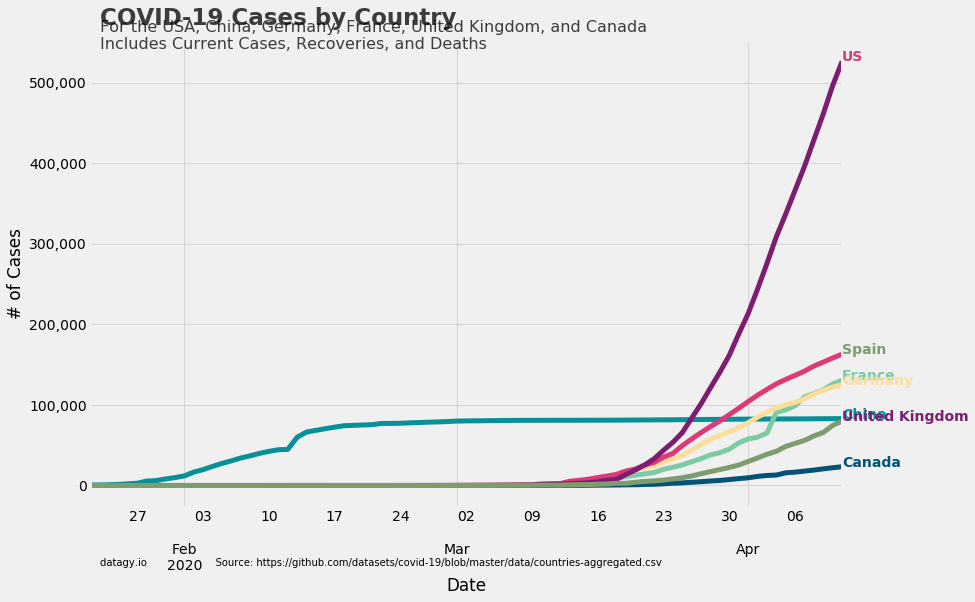

In [31]:
# Section 6 - Generating Colours and Style
colors = {'Canada':'#045275', 'China':'#089099', 'France':'#7CCBA2', 'Germany':'#FCDE9C', 'US':'#DC3977', 'United Kingdom':'#7C1D6F', 'Spain':'#7D9D6F'}
plt.style.use('fivethirtyeight')

# Section 7 - Creating the Visualization
plot = covid.plot(figsize=(12,8), color=list(colors.values()), linewidth=5, legend=False)
plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_xlabel('Date')
plot.set_ylabel('# of Cases')

# Section 8 - Assigning Colour
for country in list(colors.keys()):
    plot.text(x = covid.index[-1], y = covid[country].max(), c = colors[country], s = country, weight = 'bold')

# Section 9 - Adding Labels
plot.text(x = covid.index[1], y = int(covid.max().max())+45000, s = "COVID-19 Cases by Country", fontsize = 23, weight = 'bold', alpha = .75)
plot.text(x = covid.index[1], y = int(covid.max().max())+15000, s = "For the USA, China, Germany, France, United Kingdom, and Canada\nIncludes Current Cases, Recoveries, and Deaths", fontsize = 16, alpha = .75)
plot.text(x = percapita.index[1], y = -100000,s = 'datagy.io                      Source: https://github.com/datasets/covid-19/blob/master/data/countries-aggregated.csv', fontsize = 10)


In [32]:
countries = df.Country.unique()
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

In [33]:
#sorting based on confirmed cases to identify top-10 countries with highest confirmed cases
grouped = df.groupby(['Country']).agg({'Confirmed': 'max', 'Deaths': 'max'}).sort_values(by=['Confirmed'], ascending=False).reset_index()
top_10 = list(grouped.Country[0:10])
top_10



['US',
 'Spain',
 'Italy',
 'France',
 'Germany',
 'China',
 'United Kingdom',
 'Iran',
 'Turkey',
 'Belgium']

In [34]:
grouped_country = df.groupby(['Country', 'Date']).agg({'Confirmed': 'max', 'Deaths': 'max'}).reset_index()
grouped_country['newCases'] = grouped_country['Confirmed'].diff().fillna(0)
grouped_country['newDeaths'] = grouped_country['Deaths'].diff().fillna(0)

In [35]:
grouped_country.head()

Country       Date  Confirmed  Deaths  newCases  newDeaths
0  Afghanistan 2020-01-22          0       0       0.0        0.0
1  Afghanistan 2020-01-23          0       0       0.0        0.0
2  Afghanistan 2020-01-24          0       0       0.0        0.0
3  Afghanistan 2020-01-25          0       0       0.0        0.0
4  Afghanistan 2020-01-26          0       0       0.0        0.0

In [36]:
# Mapping codes to countries in dataset
grouped['code'] = grouped['Country'].map(complete_country_code_dict)
# Double checking missing values
missing_codes = len(grouped[grouped.code == 'Unknown code'][['Country']])
print(f'There are {missing_codes} missing 3-letter codes in dataset')
print('-------')
grouped.head()

There are 0 missing 3-letter codes in dataset
-------


Country  Confirmed  Deaths code
0       US     526396   20463  USA
1    Spain     163027   16606  ESP
2    Italy     152271   19468  ITA
3   France     130727   13851  FRA
4  Germany     124908    2767  DEU

In [37]:
# Mapping pop data
# Mapping codes to countries in dataset
grouped['over_65'] = grouped['Country'].map(over_65_dict)
# Double checking missing values
missing_pops = len(grouped[grouped.over_65.isna()])
print(f'There are {missing_pops} missing age data in dataset')
print('-------')
grouped.head()

There are 26 missing age data in dataset
-------


Country  Confirmed  Deaths code    over_65
0       US     526396   20463  USA        NaN
1    Spain     163027   16606  ESP  19.378508
2    Italy     152271   19468  ITA  22.751680
3   France     130727   13851  FRA  20.034625
4  Germany     124908    2767  DEU  21.461962

In [39]:
grouped[grouped.over_65.isna()]

Country  Confirmed  Deaths code  over_65
0                                  US     526396   20463  USA      NaN
7                                Iran      70029    4357  IRN      NaN
16                             Russia      13584     106  RUS      NaN
18                       Korea, South      10480     211  KOR      NaN
31                            Czechia       5831     129  CZE      NaN
53                              Egypt       1939     146  EGY      NaN
74                           Slovakia        728       2  SVK      NaN
75                   Diamond Princess        712      11  UNK      NaN
94                            Taiwan*        385       6  TWN      NaN
98                         Kyrgyzstan        339       5  KGZ      NaN
109                  Congo (Kinshasa)        223      20  COD      NaN
113                         Venezuela        175       9  VEN      NaN
115                            Brunei        136       1  BWN      NaN
129               Congo (Brazzaville)         60       5  COG      NaN
132                           Bahamas         46       8  BHS      NaN
136                             Burma         38       3  MMR      NaN
142                             Syria         25       2  SYR      NaN
150                              Laos         18       0  LAO      NaN
156                       Saint Lucia         15       0  LCA      NaN
162             Saint Kitts and Nevis         12       0  KNA      NaN
163  Saint Vincent and the Grenadines         12       0  VCT      NaN
168                            Gambia          9       1  GMB      NaN
169                        MS Zaandam          9       2  UNK      NaN
172                          Holy See          8       0  VAT      NaN
180                    Western Sahara          4       0  ESH      NaN
184                             Yemen          1       0  YEM      NaN

In [40]:
no_pop_data = list((grouped[grouped.over_65.isna()])['Country'])
augment_pop_data = [15.2, 6.18, 14.42, 14.67, 19.42, 4.3, 'no data', 15.97, 14.94, 6.2, 2.69, 7.38, 5.17, 3.1, 7.2576, 5.3, 4.31, 3.95, 13.1, 9.03, 9.82, 'no data', 'no data', 'no data', 3.55]
pop_to_augment_dict = dict(zip(no_pop_data, augment_pop_data))
pop_to_augment_dict

# Augmenting previous dictionary
complete_country_pop_dict = {**pop_to_augment_dict, **over_65_dict} 
with open('pickled_files/complete_country_pop_dict.pkl', 'wb') as f:
    pickle.dump(complete_country_pop_dict, f)

# Remapping pop to missing countries
grouped['over_65'] = grouped['Country'].map(complete_country_pop_dict)
missing_ages = len(grouped[grouped.over_65.isna()])

In [41]:
no_pop_data

['US',
 'Iran',
 'Russia',
 'Korea, South',
 'Czechia',
 'Egypt',
 'Slovakia',
 'Diamond Princess',
 'Taiwan*',
 'Kyrgyzstan',
 'Congo (Kinshasa)',
 'Venezuela',
 'Brunei',
 'Congo (Brazzaville)',
 'Bahamas',
 'Burma',
 'Syria',
 'Laos',
 'Saint Lucia',
 'Saint Kitts and Nevis',
 'Saint Vincent and the Grenadines',
 'Gambia',
 'MS Zaandam',
 'Holy See',
 'Western Sahara',
 'Yemen']

In [45]:
# Adding population data
complete_country_pop_dict = pd.read_pickle('pickled_files/complete_country_pop_dict.pkl')

# Mapping population data to countries
grouped['over_65'] = grouped['Country'].map(complete_country_pop_dict)

In [46]:
# # Opening pickled dictionary with population data and mapping to countries
# over_65_dict = pd.read_pickle('./pickled_files/age_dict.pkl')
# # Mapping populations to countries in dataset
# grouped['population'] = grouped['Country'].map(pop_dict)
# # Double checking missing values
# missing_populations = len(grouped[grouped.code.isna()][['population']])
# print(f'There are {missing_populations} missing 3-letter codes in dataset')
# print('-------')
# .head()

In [47]:
grouped.head()

Country  Confirmed  Deaths code  over_65
0       US     526396   20463  USA     15.2
1    Spain     163027   16606  ESP  19.3785
2    Italy     152271   19468  ITA  22.7517
3   France     130727   13851  FRA  20.0346
4  Germany     124908    2767  DEU   21.462

In [48]:
def world_map_2():
    

    fig = px.choropleth(
                            grouped,
                            locations='code',
                            #title="Custom layout.hoverlabel formatting",
                            hover_name="Country",
                            hover_data=["Confirmed", "Deaths"],
                            color=grouped["Confirmed"],
                            color_continuous_scale='Reds',
                            #range_color=(0, 100),
                            labels={
                                'Confirmed': 'Confirmed Cases <br> (x10) <br>',
                                'Deaths': 'Deaths'
                            },
                            #featureidkey="global_data.Deaths",
                            scope='world',
                            #animation_frame=grouped.Date.astype(str)
                       )
    fig.update_layout(template="plotly_dark", margin={
            "r": 0,
            "t": 0,
            "l": 0,
            "b": 0
        }, coloraxis_showscale=False, # Set to True to show colorscale bar
                          coloraxis_colorbar=dict(
                              title="<b>Confirmed Cases</b> <br>" + "(Log Scale)",
                              tickvals=[1.5, 2.5, 3.5, 4.5],
                              ticktext=["100", "1k", "10k", "100k"],
                              thicknessmode="pixels",
                              thickness=10,
                              lenmode="pixels",
                              len=200,
                          ),
                          hovermode="x",
                          hoverlabel=dict(
                              bgcolor="#BF4025",
                              font_size=16,
                          ),
                          geo=dict(showframe=False,
                                   showcoastlines=False,
                                   projection_type='natural earth'))

    fig.update_traces(hovertemplate='<b>' + grouped['Country'] +
                          '</b>' + '<br>' + 'Confirmed Cases: ' +
                          grouped['Confirmed'].astype(str) + '<br>' +
                          'Deaths: ' + grouped['Deaths'].astype(str))
    return fig

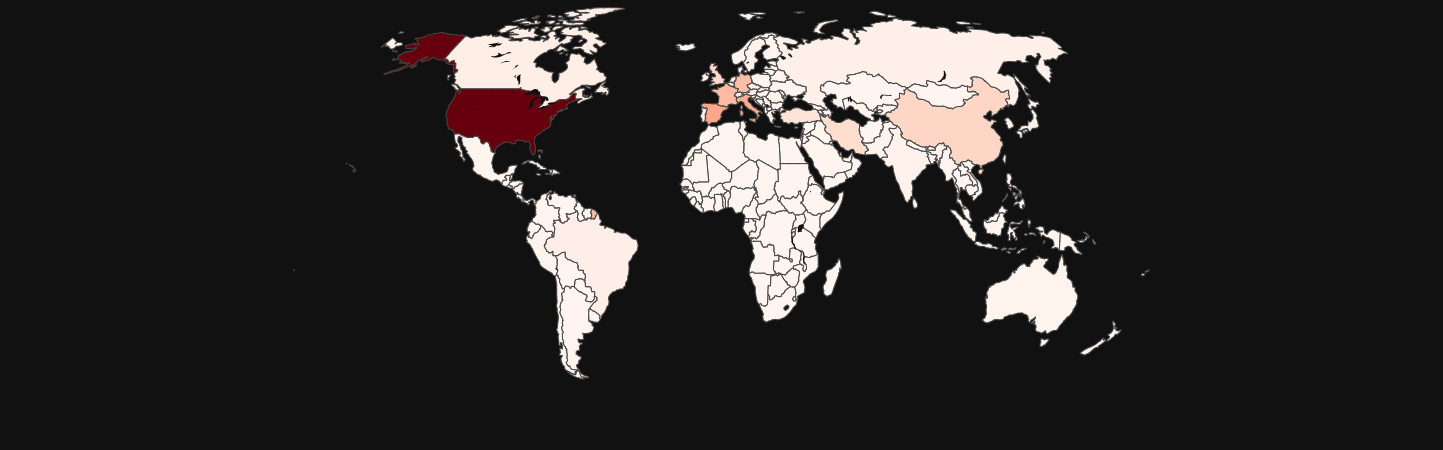

In [49]:
world_map_2()

In [50]:
def lineChart():

    # Top-10
    countries = top_10
    df_select = df[df['Country'].isin(countries)].copy()
    df_select
    fig = px.line(df_select, x="Date", y="Confirmed", color='Country')
    fig.update_xaxes(title='')
    fig.update_yaxes(title='Cummulative Cases')
    # fig.update_traces(textposition='top center')


    # fig.update_traces(texttemplate='%{text:.2s}')
    fig.update_layout(template="plotly_dark")
    
#     fig.update_traces(hovertemplate='<b>' + df_select['Country'] +
#                           '</b>' + '<br>' + 'Date: ' +
#                           df_select['Date'].astype(str) + '<br>' +
#                           'Confirmed Cases: ' + df_select['Confirmed'].astype(str))

    fig.show()

#animation_group='Country', animation_frame=df_select.Date.astype(str)

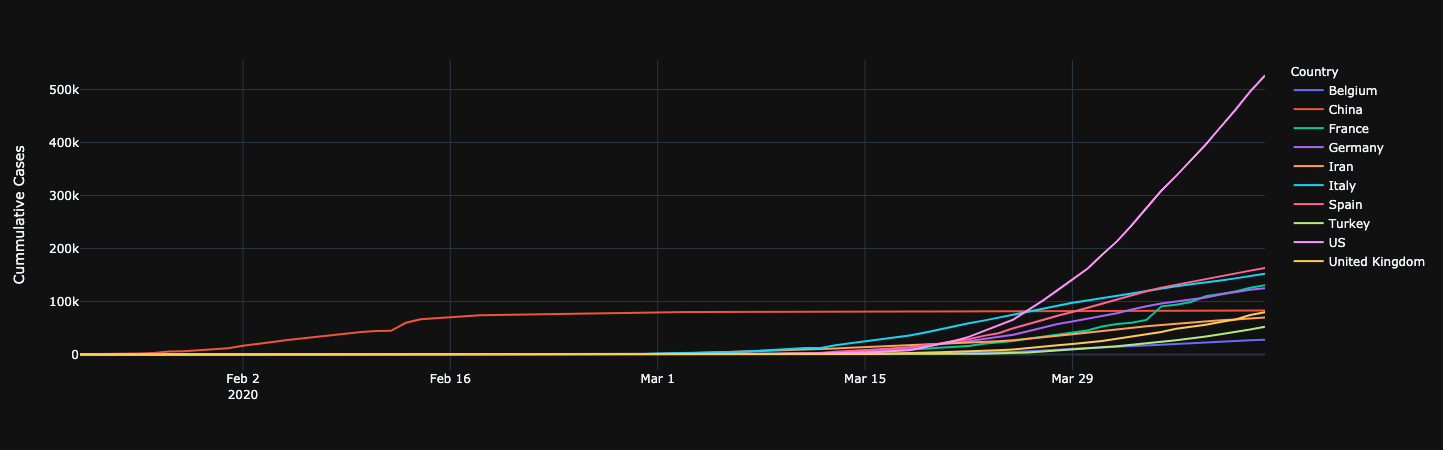

In [51]:
lineChart()

In [52]:
def perCapita():

    # Top-10
    countries = top_10
    df_select = df[df['Country'].isin(countries)].copy()
    df_select
    fig = px.line(df_select, x="Date", y="confirmedPerCapita", color='Country')
    fig.update_xaxes(title='')
    fig.update_yaxes(title='Cummulative Cases per 100,000')
    # fig.update_traces(textposition='top center')


    # fig.update_traces(texttemplate='%{text:.2s}')
    fig.update_layout(template="plotly_dark")
    
    fig.update_traces(hovertemplate='<b>' + df_select['Country'] +
                          '</b>' + '<br>' + 'Date: ' +
                          df_select['Date'].astype(str) + '<br>' +
                          'Confirmed Cases 100,000: ' + df_select['confirmedPerCapita'].astype(str))

    return fig

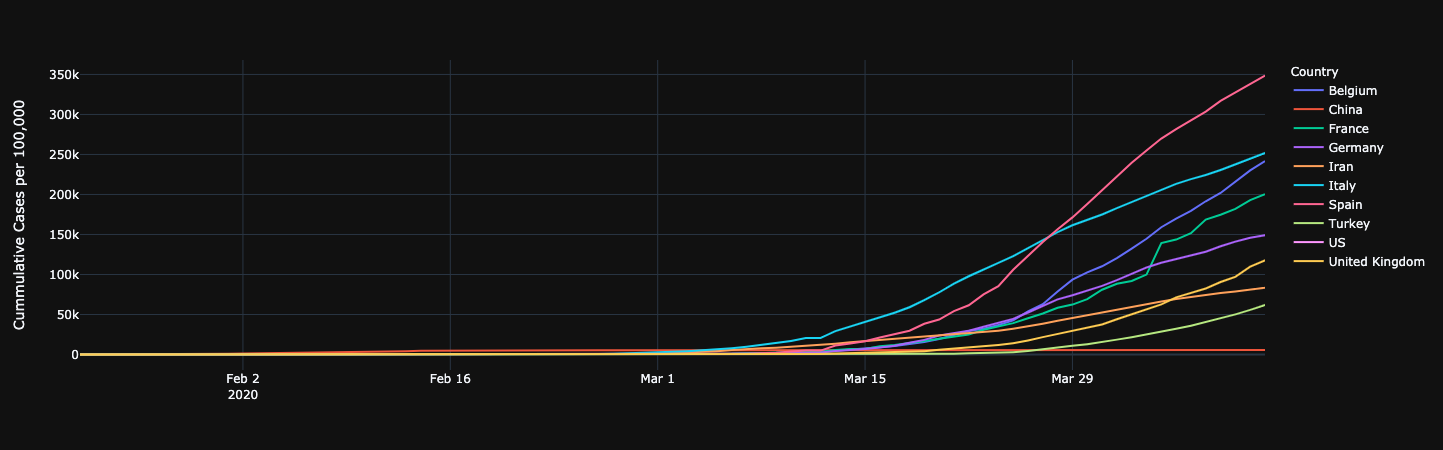

In [53]:
perCapita()

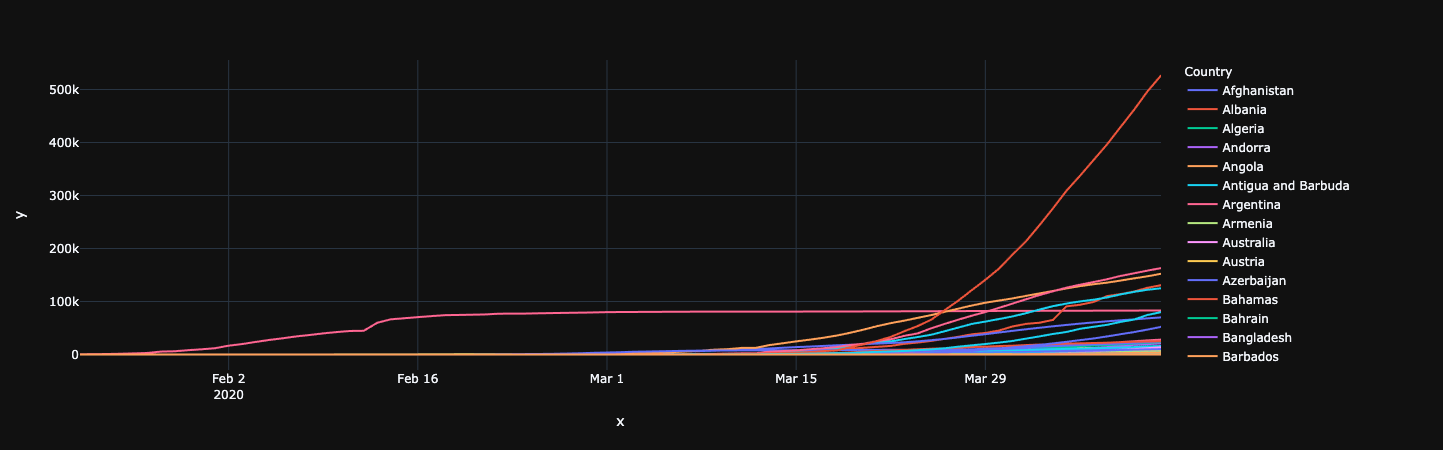

In [54]:
fig = px.line(df, x=df[df['Country'].isin(countries)]['Date'], y=df[df['Country'].isin(countries)]['Confirmed'], color='Country')
fig.update_layout(template="plotly_dark")
fig.show()

In [55]:
# # Initialize figure with subplots
# fig = make_subplots(
#     rows=1, cols=2,
#     column_widths=[0.6, 0.4],
#     row_heights=[0.4, 0.6],
#     specs=[[{"type": "line", }, {"type": "bar"}]])

# # Add line chart
# fig.add_trace(
#     go.Line(x=df_select.Date,y=df_select.Confirmed, marker=dict(color="crimson"), showlegend=False),
#     row=1, col=2
# )

# # Add 3d surface of volcano
# fig.add_trace(
#     go.Surface(z=df_v.values.tolist(), showscale=False),
#     row=2, col=2
# )

# # Update geo subplot properties
# fig.update_geos(
#     projection_type="orthographic",
#     landcolor="white",
#     oceancolor="MidnightBlue",
#     showocean=True,
#     lakecolor="LightBlue"
# )

# # Rotate x-axis labels
# fig.update_xaxes(tickangle=45)

# # Set theme, margin, and annotation in layout
# fig.update_layout(
#     template="plotly_dark",
#     margin=dict(r=10, t=25, b=40, l=60),
#     annotations=[
#         dict(
#             text="Source: NOAA",
#             showarrow=False,
#             xref="paper",
#             yref="paper",
#             x=0,
#             y=0)
#     ]
# )

# fig.show()

In [56]:
#world_data.date.max()

In [57]:
df

Date             Country  Confirmed  Recovered  Deaths  \
0     2020-01-22         Afghanistan          0          0       0   
1     2020-01-22             Albania          0          0       0   
2     2020-01-22             Algeria          0          0       0   
3     2020-01-22             Andorra          0          0       0   
4     2020-01-22              Angola          0          0       0   
...          ...                 ...        ...        ...     ...   
14980 2020-04-11  West Bank and Gaza        268         57       2   
14981 2020-04-11      Western Sahara          4          0       0   
14982 2020-04-11               Yemen          1          0       0   
14983 2020-04-11              Zambia         40         28       2   
14984 2020-04-11            Zimbabwe         14          0       3   

       population  confirmedPerCapita  deathPerCapita  
0       38928.346            0.000000        0.000000  
1        2877.797            0.000000        0.000000  
2       43851.044            0.000000        0.000000  
3          77.265            0.000000        0.000000  
4       32866.272            0.000000        0.000000  
...           ...                 ...             ...  
14980         NaN                 NaN             NaN  
14981         NaN                 NaN             NaN  
14982   29825.964            3.352784        0.000000  
14983   18383.955          217.581037       10.879052  
14984   14862.924           94.194117       20.184454  

[14985 rows x 8 columns]

In [58]:
grouped_country

Country       Date  Confirmed  Deaths  newCases  newDeaths
0      Afghanistan 2020-01-22          0       0       0.0        0.0
1      Afghanistan 2020-01-23          0       0       0.0        0.0
2      Afghanistan 2020-01-24          0       0       0.0        0.0
3      Afghanistan 2020-01-25          0       0       0.0        0.0
4      Afghanistan 2020-01-26          0       0       0.0        0.0
...            ...        ...        ...     ...       ...        ...
14980     Zimbabwe 2020-04-07         11       2       1.0        1.0
14981     Zimbabwe 2020-04-08         11       3       0.0        1.0
14982     Zimbabwe 2020-04-09         11       3       0.0        0.0
14983     Zimbabwe 2020-04-10         13       3       2.0        0.0
14984     Zimbabwe 2020-04-11         14       3       1.0        0.0

[14985 rows x 6 columns]

In [59]:
#####################
# Cummulative Cases #
#####################



def cummulativeCases(country, metric):

    fig = px.line(grouped_country, x=grouped_country[grouped_country['Country'] == country]['Date'], 
                 y=grouped_country[grouped_country['Country'] == country][metric])

    fig.update_layout(template="plotly_dark")
    fig.update_xaxes(title='')
    fig.update_yaxes(title='Cummulative ' + metric + ' Cases')

    fig.update_traces(hovertemplate= 'Total Cases: ' + grouped_country[grouped_country['Country'] == country][metric].astype(str))

    return fig

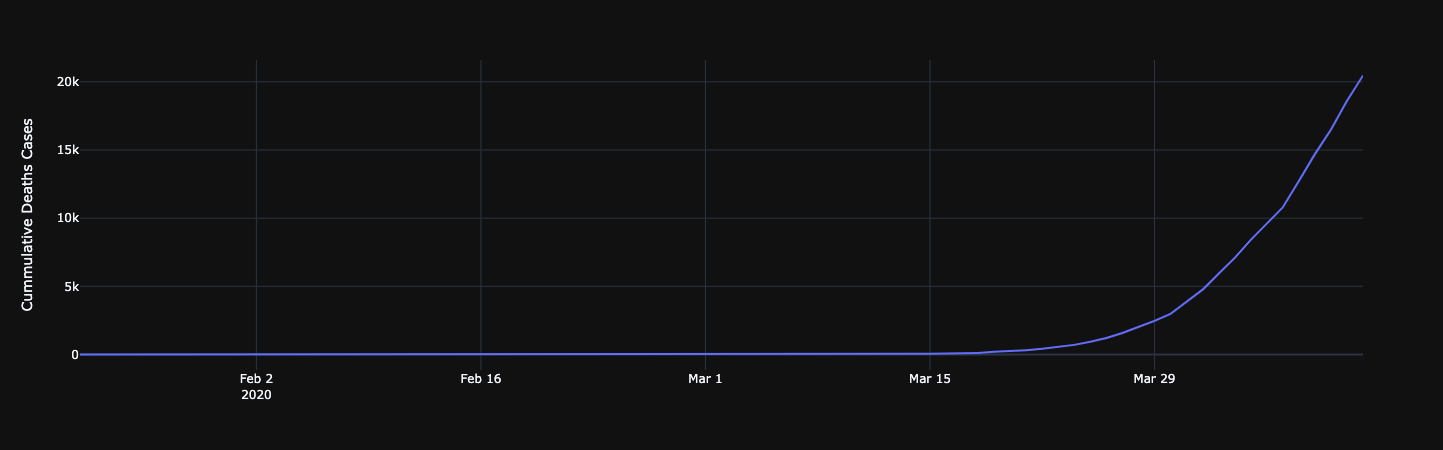

In [60]:
cummulativeCases('US', 'Deaths')

In [61]:
#####################
# New Cases per Day #
#####################

def newCases(country, metric, yaxisTitle=""):

    fig = px.bar(grouped_country,
                 x=grouped_country[grouped_country['Country'] == country]['Date'][1:],
                 y=grouped_country[grouped_country['Country'] == country]['new' + metric][1:])

    fig.update_layout(template="plotly_dark")
    fig.update_xaxes(title='')
    fig.update_yaxes(title='New Cases per Day')

    fig.update_traces(hovertemplate='New Cases: ' +
                      grouped_country[grouped_country['Country'] == country][metric].astype(str))

    return fig

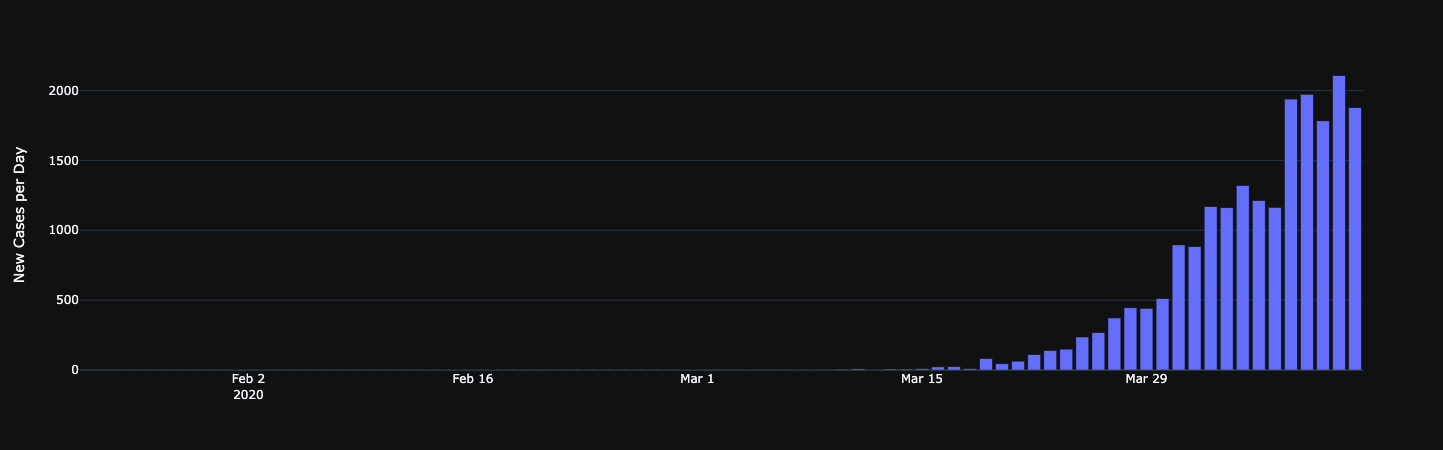

In [62]:
newCases('US', 'Deaths')

In [63]:
grouped_country[grouped_country.Country == 'US'][1:]

Country       Date  Confirmed  Deaths  newCases  newDeaths
13852      US 2020-01-23          1       0       0.0        0.0
13853      US 2020-01-24          2       0       1.0        0.0
13854      US 2020-01-25          2       0       0.0        0.0
13855      US 2020-01-26          5       0       3.0        0.0
13856      US 2020-01-27          5       0       0.0        0.0
...       ...        ...        ...     ...       ...        ...
13927      US 2020-04-07     396223   12722   29556.0     1939.0
13928      US 2020-04-08     429052   14695   32829.0     1973.0
13929      US 2020-04-09     461437   16478   32385.0     1783.0
13930      US 2020-04-10     496535   18586   35098.0     2108.0
13931      US 2020-04-11     526396   20463   29861.0     1877.0

[80 rows x 6 columns]

In [64]:
# Bar chart of fatality for top-10 countries

grouped_country['fatalityRate'] = grouped_country.Deaths/grouped_country.Confirmed*100


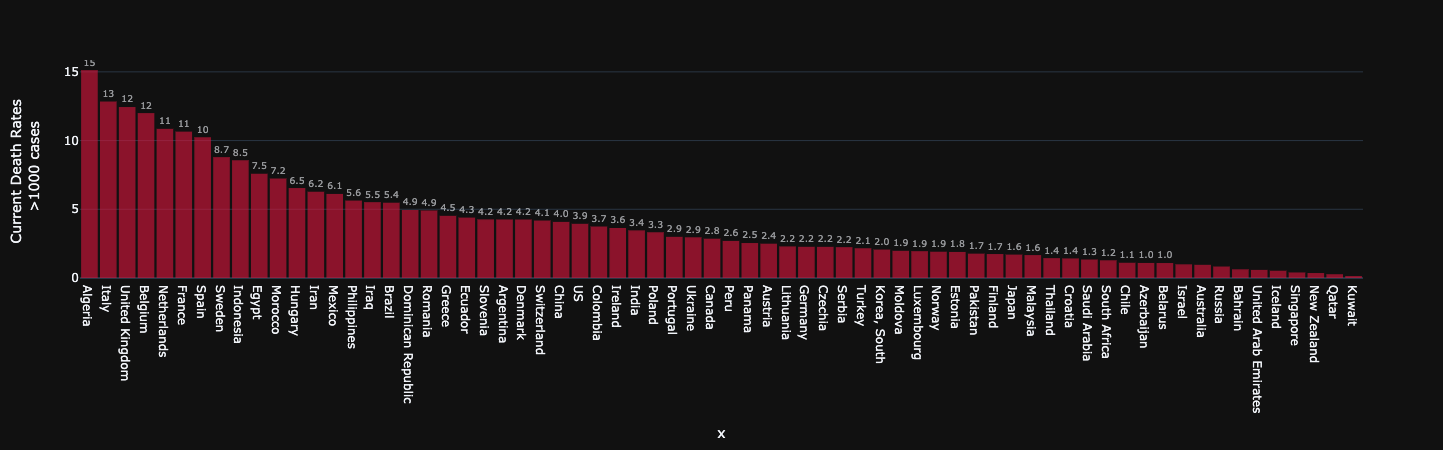

In [65]:
#################
# Fatality Rate #
#################



grouped['fatalityRate'] = grouped.Deaths/grouped.Confirmed*100

def fatalityRate():
    # Limiting graph to countries with more than 1000 cases
    x = grouped[grouped.Confirmed > 1000]["Country"]
    y = grouped[grouped.Confirmed > 1000]["fatalityRate"]

    fig = px.bar(grouped, x=x, y=y, text=grouped[grouped.Confirmed > 1000]["fatalityRate"])
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside', marker_color='crimson', marker_line_color='crimson',
                      marker_line_width=1.5, opacity=0.6)
    fig.update_layout(xaxis={'categoryorder':'total descending'}, template="plotly_dark", yaxis={'title': 'Current Death Rates <br> >1000 cases'}, uniformtext_minsize=9, uniformtext_mode='hide')
    fig.show()
fatalityRate()

In [66]:
grouped.head()

Country  Confirmed  Deaths code  over_65  fatalityRate
0       US     526396   20463  USA     15.2      3.887378
1    Spain     163027   16606  ESP  19.3785     10.186043
2    Italy     152271   19468  ITA  22.7517     12.785100
3   France     130727   13851  FRA  20.0346     10.595363
4  Germany     124908    2767  DEU   21.462      2.215230

In [82]:
# Scatter of fatality rate vs population over 65
grouped['fatalityRate'] = grouped.Deaths/grouped.Confirmed*100
grouped.loc[grouped['Deaths'] > 3000, 'Annotation'] = grouped['Country']
grouped.loc[grouped['Deaths'] <= 3000, 'Annotation'] = ''


def fatalityRate_65():
    x = grouped["over_65"]
    y = grouped["fatalityRate"]

    fig = px.scatter(grouped, x=x, y=y, size=grouped['Deaths'], hover_name=grouped["Country"], text='Annotation')
    fig.update_traces(marker_color='purple', marker_line_color='red',
                       marker_line_width=1.5, opacity=0.9, textposition='top right')
    fig.update_layout(template="plotly_dark", yaxis={'title': 'Case Fatality Rate (%)'}, xaxis={'title': 'Population of age 65 and above (% of total population)'}, uniformtext_minsize=14, uniformtext_mode='hide')
    
    fig.update_traces(hovertemplate='<b>' + grouped['Country'] + '</b>' +
                      '<br>' + 'CFR (%): ' +
                      round(grouped['fatalityRate'], 2).astype(str) + '<br>' + 'Population over 65: ' + grouped['over_65'].astype(str) + '<br>' +
                      'Confirmed Cases: ' + grouped['Confirmed'].astype(str) +
                      '<br>' + 'Deaths: ' + grouped['Deaths'].astype(str))
    return fig

fatalityRate_65 = fatalityRate_65()

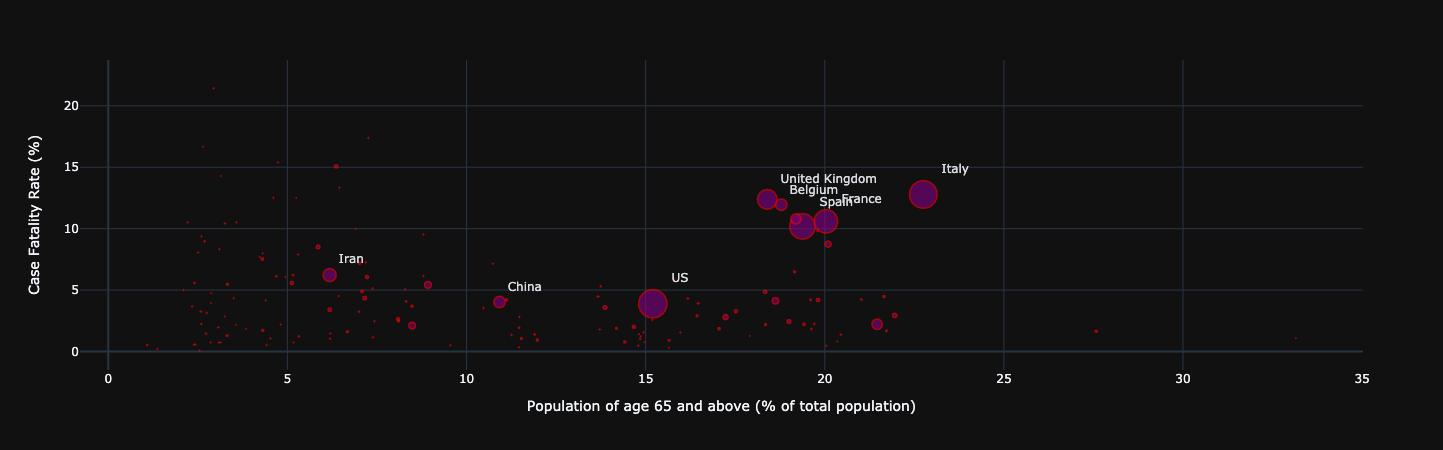

In [83]:
fatalityRate_65

In [ ]:
grouped

In [ ]:
to_show = grouped[grouped['Confirmed'] > 1000].index
not_show = grouped[grouped['Confirmed'] <= 1000].index


In [ ]:
show_country = grouped['Confirmed'] > 1000
to_show = list(grouped[show_country]['Country'])

No_show_country = grouped['Confirmed'] <= 1000
not_show = list(grouped[No_show_country]['Country'])

#annotation = to_show + not_show
to_show

In [ ]:
def world_map():

    fig = px.choropleth(
            grouped,
            locations='code',
            #title="Custom layout.hoverlabel formatting",
            hover_name="Country",
            hover_data=["Confirmed", "Deaths"],
            color=np.log10(grouped["Confirmed"]),
            color_continuous_scale='Reds',
            #range_color=(0, 100),
            labels={
                'Confirmed': 'Confirmed Cases <br> (x10) <br>',
                'Deaths': 'Deaths'
            },
            #featureidkey="global_data.Deaths",
            scope='world',
            #animation_frame=grouped.Date.astype(str)
        )
    fig.update_layout(
        template="plotly_dark",
        margin={
            "r": 0,
            "t": 0,
            "l": 0,
            "b": 0
        },
        coloraxis_showscale=False,  # Set to True to show colorscale bar
        coloraxis_colorbar=dict(
            title="<b>Confirmed Cases</b> <br>" + "(Log Scale)",
            tickvals=[1.5, 2.5, 3.5, 4.5],
            ticktext=["100", "1k", "10k", "100k"],
            thicknessmode="pixels",
            thickness=10,
            lenmode="pixels",
            len=200,
        ),
        hovermode="x",
        hoverlabel=dict(
            bgcolor="#BF4025",
            font_size=16,
        ),
        geo=dict(showframe=False,
                 showcoastlines=False,
                 projection_type='orthographic'))

    fig.update_traces(hovertemplate='<b>' + grouped['Country'] + '</b>' +
                        '<br>' + 'Confirmed Cases: ' +
                        grouped['Confirmed'].astype(str) + '<br>' + 'Deaths: ' +
                        grouped['Deaths'].astype(str))
    return fig


world_map = world_map()

In [ ]:
world_map

In [ ]:
grouped

In [ ]:
complete_country_code_dict